## Introduction

Before the 1870s, North American school systems were largely male-dominated. With hopes of shedding light on outdated gender biases on women in the education system, we will look at high school test scores and the corresponding genders of the students that wrote the tests. 

**Is there a correlation that will allow us to predict a student’s gender based on their test scores and if so, how accurately?** We will be looking at a dataset on Kaggle (https://www.kaggle.com/spscientist/students-performance-in-exams) that uses data collected in the USA to answer this question.

## Preliminary Data Analysis and Methods

We first have to load the `tidyverse`, `repr`, and `tidymodels` libraries.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
install.packages('gsheet')
library(gsheet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.8      ✔ rsample   0.0.7 
✔ infer     0.5.3      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.1.3 
✔ parsnip   0.1.3    

To read in the data, we downloaded the dataset, looked at its storage link and used `read_csv` since the values were separated by commas. 

In [2]:

kaggle <- "https://docs.google.com/spreadsheets/d/17G-ujDXnOWzrayNUAV3lmsjhrwd3GPwIRC8_zQA1L8U/edit#gid=0"

doc <- gsheet2text(kaggle, format='csv')

perf <- read_csv(file = doc)

head(perf)

Parsed with column specification:
cols(
  gender = col_character(),
  `race/ethnicity` = col_character(),
  `parental level of education` = col_character(),
  lunch = col_character(),
  `test preparation course` = col_character(),
  `math score` = col_double(),
  `reading score` = col_double(),
  `writing score` = col_double()
)



gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
female,group B,bachelor's degree,standard,none,72,72,74
female,group C,some college,standard,completed,69,90,88
female,group B,master's degree,standard,none,90,95,93
male,group A,associate's degree,free/reduced,none,47,57,44
male,group C,some college,standard,none,76,78,75
female,group B,associate's degree,standard,none,71,83,78


### Data Wrangling

There are a number of modifications that we have to make before working with this data:

- Remove the spaces and '/' symbols from our column names 
- Other than gender and the three numerical test-score columns, the other columns can be excluded 


In [3]:
perf_gen <- perf %>%
               rename("parent_education"= "parental level of education", 
               "race_ethnicity" = "race/ethnicity", 
               "math_score" = "math score", 
               "reading_score" = "reading score", 
               "writing_score" = "writing score",
              "test_prep_course" = "test preparation course") %>%
               select(gender, math_score, reading_score, writing_score)
    

head(perf_gen)


gender,math_score,reading_score,writing_score
<chr>,<dbl>,<dbl>,<dbl>
female,72,72,74
female,69,90,88
female,90,95,93
male,47,57,44
male,76,78,75
female,71,83,78


The `gender` column is our categorical statistical variable and was converted into a factor. 

In [4]:
perf_gen  <- perf_gen %>%
             mutate(gender = as_factor(gender))

### Summarizing The Data

We arbitrarily decided to use 3/4 of the data for training and 1/4 for testing as this would give us plenty of data to train our classifier.

In [5]:
set.seed(1)
perf_split <- initial_split(perf_gen, prop = 0.75, strata = gender)
perf_train <- training(perf_split)
perf_test <- testing(perf_split)

In [6]:
num_obs <- nrow(perf_train) ## number of observations in whole dataset

perf_train %>%
  group_by(gender) %>%
  summarize("Number of People"= n(), Percent = n()/ num_obs *100) 
  

`summarise()` ungrouping output (override with `.groups` argument)



gender,Number of People,Percent
<fct>,<int>,<dbl>
female,389,51.7976
male,362,48.2024


From the above table, we know:
- categories under `gender` include only males and females
- training data is fairly evenly split (51.8% being female and 48.2% being male)

We then investigated wheteher or not there was stratification regarding how well one gender scored over another. 

In [7]:
average_test_scores <- perf_train %>%
                       group_by(gender) %>%
                       summarize(avg_math = mean(math_score),
                                 avg_reading = mean(reading_score),
                                 avg_writing = mean(writing_score))
average_test_scores

`summarise()` ungrouping output (override with `.groups` argument)



gender,avg_math,avg_reading,avg_writing
<fct>,<dbl>,<dbl>,<dbl>
female,63.74293,72.86889,72.82776
male,68.20994,65.02210,62.90608


### Plotting the Data

From this table, all test scores appear to be suitable predictors because there is a clear difference between all mean scores and genders. Since these values are averages, we need to visualize all the points on the training data as scatter plots to see which two predictors would result in the most distinct clusters of points.

cowplot code found on: https://stackoverflow.com/questions/1249548/side-by-side-plots-with-ggplot2)

Palette from: http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/.

Warning message:
“package ‘cowplot’ was built under R version 4.0.2”


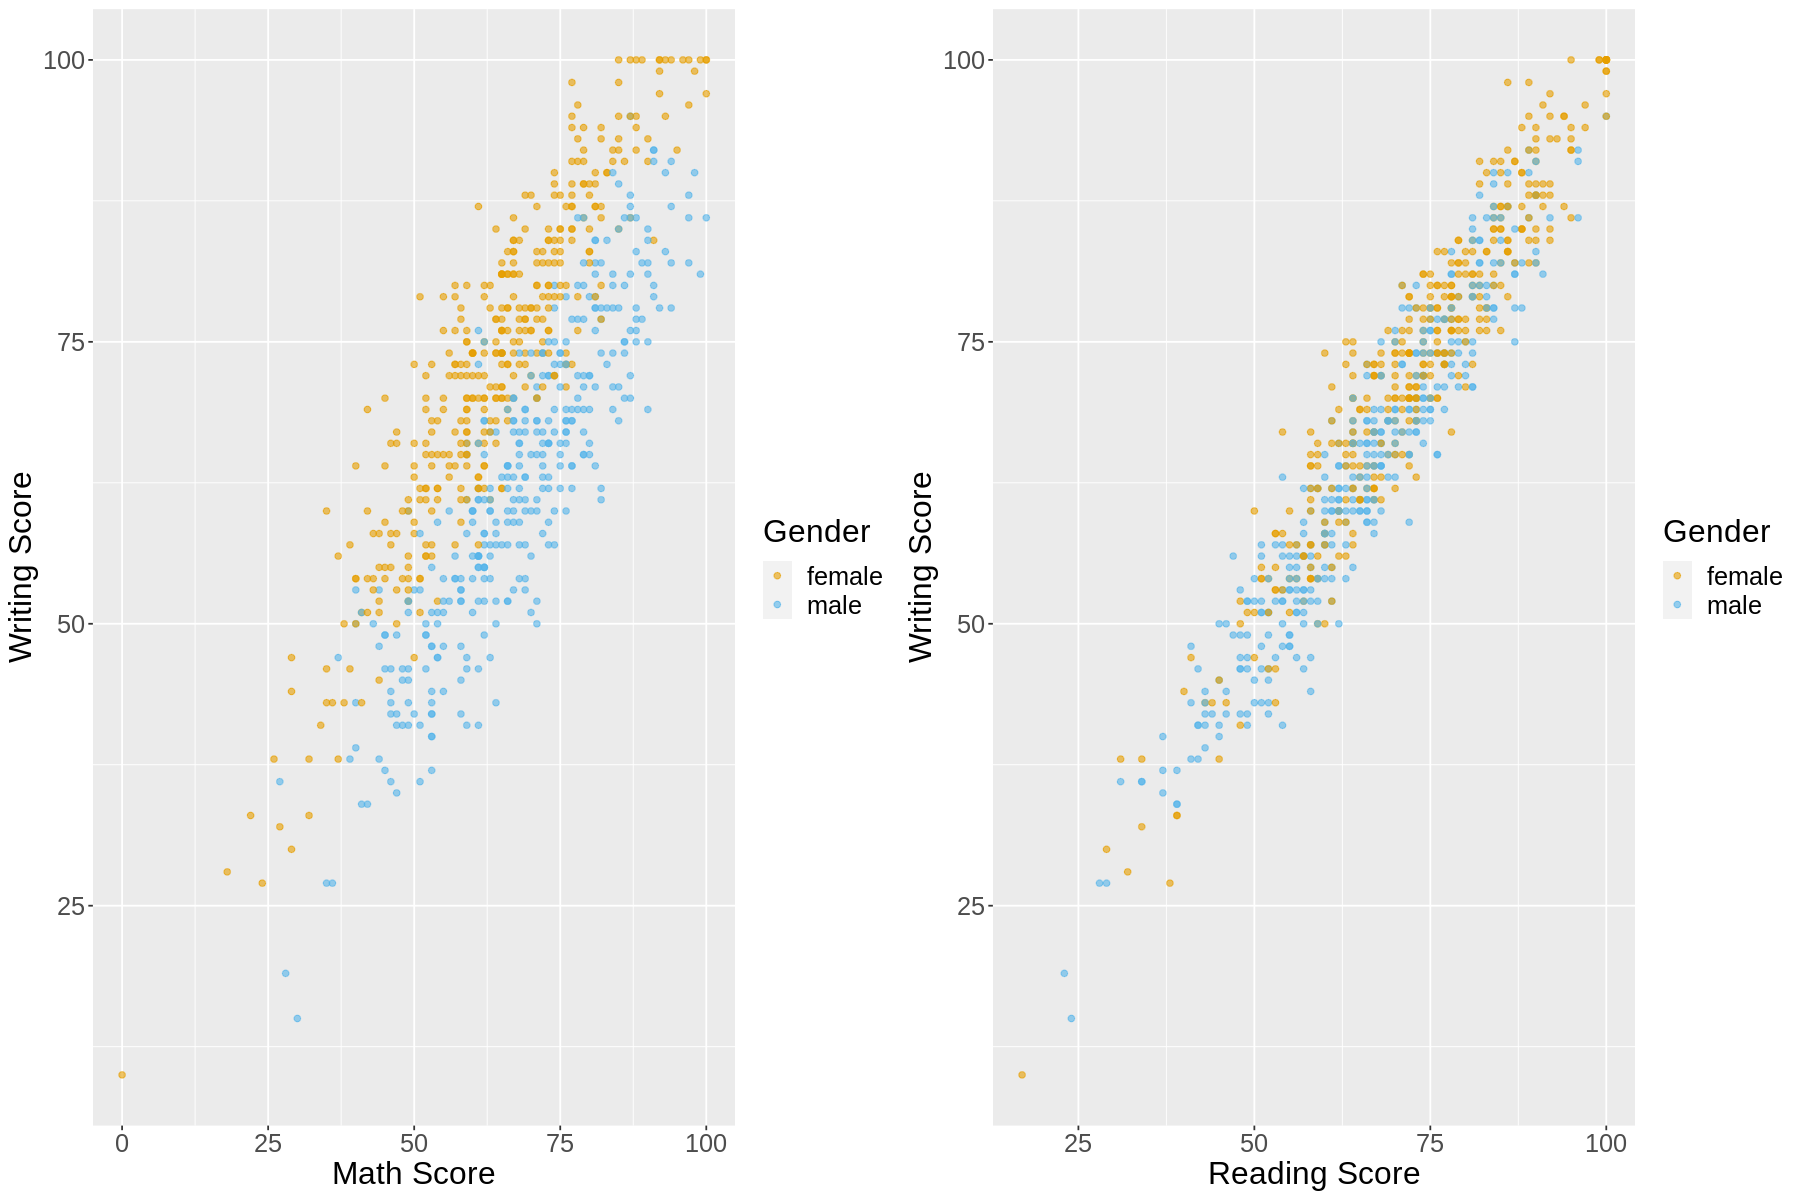

In [8]:
options(repr.plot.width = 15, repr.plot.height = 10)

library(cowplot)

cbPalette <- c( "#E69F00", "#56B4E9","#999999", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7") 
## using a colour-blind friendly palette


math_writing <- perf_train %>%
              ggplot(aes(x= math_score, y = writing_score, colour = gender)) +
              geom_point(alpha = 0.6) + 
              labs(x = "Math Score", y = "Writing Score", colour = "Gender") +
              theme(text = element_text(size = 19)) +
              scale_color_manual(values = cbPalette)

reading_writing <- perf_train %>%
              ggplot(aes(x= reading_score, y = writing_score, colour = gender)) +
              geom_point(alpha = 0.6) + 
              labs(x = "Reading Score", y = "Writing Score", colour = "Gender") +
              theme(text = element_text(size = 19)) +
              scale_color_manual(values = cbPalette)

plot_grid(math_writing, reading_writing)

### Building the Model

Employing `writing_score` and `math_score` (in comparison to `reading_score`) as our axes resulted in a much clearer split between the two groups. Therefore, the quantitative variables that we will be using as predictors will be `math_score` and `writing_score`. Depending on the accuracy of our initial model, we may also choose to add `reading_score` as a third predictor if it increases the accuracy. Judging by the graphs and summarized tables we had, we also don't need to worry about overplotting or NA values. 


Using the training data, we will follow the steps below in order to make our predictive model: 

1. Use `v_fold` to split up our data and perform 5-fold cross-validation. This allows us to select an optimal $K$ value for KNN-classification. 
2. Create a recipe that uses `math_score` and `writing_score` as predictors.
- Will not need to scale our data as `math_score` and `writing_score` use the same scale and are comparable.
- There are also relatively equal numbers of female and male observations, so we also will not need to balance our data. 
3. Create a `nearest_neighbours` model specification with tuning on the number of neighbours.
4. Using our model and specification, we can create a workflow that runs cross-validation on each validation split.
5. Plot accuracy vs. $K$ to pick the best value of $K$. 
6. Make a new model classification using our chosen $K$ value and retrain the classifier. 
7. Evaluate the accuracy of our classifier using `predict`. 


### Visualizing the Results of Our Model

To visualize the accuracy of our predicted results, we will create two scatter
 plots. The first scatter plot will display the *predicted classification* results for a set number of observations (i.e. 50 observations) and the second scatter plot will display the *actual observations*. Comparing the two plots will allow us to see the accuracy of our classifier.

## Expected Outcomes and Significance

From the above analysis and dataset, we expect to find that math and reading test scores can be used to predict gender with a relatively high accuracy. 

Such findings would have a major impact on our perception of academic differences between males and females. If test scores can actually be used to predict the gender of a student, it suggests that there is an inequality in terms of how male and female students are being taught or how they are learning. 

Information in this dataset could lead to future questions such as:

*How does school location influence the difference between the average test scores of males and females?* 

*How accurately do test scores predict the gender and test preparation of a student?*
